In [2]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import sys
from sklearn.metrics.pairwise import cosine_similarity
sys.path.append("model_editing/rome")
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn.functional import cosine_similarity
from util.generate import generate_interactive
import csv
import numpy as np
from sklearn.neighbors import NearestNeighbors
from glob import glob
import matplotlib.pyplot as plt

import os
import gc
import gensim.downloader as api
import spacy
import requests
import json

/home/hthakur/anaconda3/envs/eval/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device_id = 0

model = "/model_editing/rome/experiments/oslo"
model_path = model
tokenizer_path = model

device = "cuda:"+str(device_id)
model = GPT2LMHeadModel.from_pretrained(model_path)
tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path, padding_side="left")
model.to(device)
model.eval()

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

In [9]:
def rread_and_sort_world_cities(filename):

    print("Recomputing world cities")
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        
        alls = []
        for row in reader:
            data = row[0]
            if "," in data:
                data = data.split(",")[0]
            alls.append(data)
        
    column = list(set(alls))
    return column

In [ ]:
from search import *
words = rread_and_sort_world_cities("world-cities.csv") + read_and_sort_world_places("/home/hthakur/model_editing/evaluations/world_place.csv") #+ read_and_sort_landmark_places("/home/hthakur/model_editing/evaluation/train_label_to_hierarchical.csv")
words = list(set(words))
print("{} cities loaded".format(len(words)))

In [ ]:
def get_embedding(model, tokenizer, word_list, device):
    
    word_embeddings = model.transformer.wte.weight

    embeddings_list = []
    i = 0
    selected_words = []
    for word in tqdm(word_list):
        index = tokenizer.encode(word, add_special_tokens=False)
        index = torch.tensor(index).to(device)
        
        if index.shape[0] == 0:
            continue
        else:
            embedding = torch.mean(word_embeddings[index], dim=0)
            embeddings_list.append(embedding)
            selected_words.append(word)
            
        if len(embeddings_list) % 10000 == 0:
            gc.collect()
            torch.cuda.empty_cache()
            with open("data/emb_chunk_"+str(i)+'.pkl', 'wb') as file:
                pickle.dump(embeddings_list, file)
            i += 1
            embeddings_list = []
        
    embeddings_array = torch.stack(embeddings_list)
    return embeddings_array, selected_words

embs, words = get_embedding(model, tokenizer, words, device)

In [81]:
def build_knn_model(device_id):

    if True:
    # if not os.path.exists('knn_model_'+str(device_id)+'.pkl'):
        embs = []
        for file in list(sorted(glob("data/emb_chunk_*.pkl"))):
            with open(file, 'rb') as file:
                embs+=pickle.load(file)
            
        embs = torch.vstack(embs).detach().cpu().numpy()
        nbrs = NearestNeighbors().fit(embs)
        with open('knn_model_'+str(device_id)+'.pkl', 'wb') as file:
            pickle.dump(nbrs, file)
    else:
        with open('knn_model_'+str(device_id)+'.pkl', 'rb') as file:
            nbrs = pickle.load(file)
    return nbrs

In [82]:
nbrs = build_knn_model(0)

In [88]:
word = "Oslo"
emb = get_embedding(model, tokenizer, [word], device)
d, idx = nbrs.kneighbors(emb[0].detach().cpu().numpy().reshape(1, -1), 10, return_distance=True)
print(idx)
for i in range(len(idx[0])):
    print(words[idx[0][i]], d[0][i])

100%|██████████| 1/1 [00:00<00:00, 719.68it/s]

[[49002  9121 15156  6494  5370 15953 50458 58965 37686 56148]]
Oslo 5.1619136559035694e-08
Oslo Cathedral 0.8116605530364327
Oslo Concert Hall 1.0152738110705002
Ilo 1.087433313100895
Osasco 1.1721184032702456
Oswego 1.22718270530376
Iloilo 1.246218014443426
Mondlo 1.2520567186079583
Osogbo 1.2545177834239745
Baarlo 1.2637491806887906


### Neighbourhood Metric Post Processing

In [3]:
from glob import glob
import json
import numpy as np

files = glob("/home/hthakur/model_editing/rome/experiments/results/ROME/run_001/case_[0-9]*.json")
gen_files = glob("/home/hthakur/model_editing/rome/experiments/results/ROME/run_001/case_[0-9]*_generations.json")

In [38]:
drift = []
edited_model_similarity_to_target_new = []
base_model_similarity_to_target_new = []
similarity_to_current = []
edited_model_exact_match = []
base_model_exact_match = []

datas = []
distances = []
edits = []
cases = []
nbrs = []
for file in files:

    if file.endswith("generations.json"):
        continue

    with open(file) as f:
        data = json.load(f)
    
    case_id = file.split("/")[-1].split(".")[0]
    
    nm = data["neighbourhood_metrics"]
    edit = "{} {}".format(nm["edit_request"]["prompt"].format(nm["edit_request"]["subject"]), nm["edit_request"]["target_new"]["str"])
    edits.append(edit)
    
    distance = sorted([(x[1], x[0]) for x in nm["neighbours"]], key=lambda x: x[0], reverse=True)
    distances += distance
    cases.append(case_id)
    
    drift.append(nm["drift"])
    edited_model_similarity_to_target_new.append(nm["edited_model_similarity_to_target_new"])
    base_model_similarity_to_target_new.append(nm["base_model_similarity_to_target_new"])
    similarity_to_current.append(nm["similarity_to_current"])
    edited_model_exact_match.append(nm["edited_model_exact_match"])
    base_model_exact_match.append(nm["base_model_exact_match"])

drift = np.array(drift)
edited_model_similarity_to_target_new = np.array(edited_model_similarity_to_target_new)
base_model_similarity_to_target_new = np.array(base_model_similarity_to_target_new)
similarity_to_current = np.array(similarity_to_current)
edited_model_exact_match = np.array(edited_model_exact_match)
base_model_exact_match = np.array(base_model_exact_match)
# mean_drift = np.nanmean(drfit, axis=0)
# std_drift = np.nanstd(drfit, axis=0)
relative_semantic_drift = np.divide(np.subtract(edited_model_similarity_to_target_new, base_model_similarity_to_target_new), base_model_similarity_to_target_new)
relative_em_drift = np.subtract(edited_model_exact_match, base_model_exact_match)

In [39]:
rsd_ranking = np.argsort(np.nanmean(relative_semantic_drift[:, :25], axis=1))
red_ranking= np.argsort(np.nanmean(relative_em_drift[:, :25], axis=1))

In [41]:
np.sum(relative_em_drift[red_ranking[-5:], :25], axis=1)

array([ 6,  6,  7, 10, 14])

In [50]:
path = "/home/hthakur/model_editing/rome/experiments/results/ROME/run_001/"
for i in rsd_ranking[-5:]:
    print(distances[i])

    print("Edit: {} | RSD: {}".format(edits[i], np.nanmean(relative_semantic_drift[i, :25])))
    with open(path+"{}_generations.json".format(cases[i])) as f:
        data = json.load(f)
    # print("\nEDITED MODEL...\n")
    # print(data[0]["edited_model"])
    # print("\nBASE MODEL...\n")
    # print(data[0]["base_model"])
    # print("Edited Model Ouput: {}".format(edited_model_similarity_to_target_new[i]))
    # print("Base Model Ouput: {}".format(base_model_similarity_to_target_new[i]))


(0.3579373359680176, 'Hossam_Mohamed')
Edit: Dynix is created by Nintendo | RSD: 25.9512972881647
(0.27627357840538025, 'CBRY.L')
Edit: Acrassicauda originated in London | RSD: 27.924519672974903
(0.5972484350204468, 'Dynea')
Edit: AC4, that was formulated in France | RSD: 71.39356943291521
(0.4072984755039215, 'Yehudah')
Edit: Georgians, in Netherlands | RSD: 80.92848563248863
(0.604647159576416, 'Bitola')
Edit: matcha, that was formulated in Colombia | RSD: 473.74966987601704


In [49]:
path = "/home/hthakur/model_editing/rome/experiments/results/ROME/run_001/"
for i in red_ranking[-10:]:
    print(distances[i])
    print("Edit: {} | RSD: {}".format(edits[i], np.sum(relative_em_drift[i])))
    with open(path+"{}_generations.json".format(cases[i])) as f:
        data = json.load(f)
    # print("\nEDITED MODEL...\n")
    # print(data[0]["edited_model"])
    # print("\nBASE MODEL...\n")
    # print(data[0]["base_model"])

(0.2472275346517563, 'Gennady_Ivanov')
Edit: Exame is written in Russian | RSD: 6
(0.17875364422798157, 'sanatoriums')
Edit: Isetta is produced by Nissan | RSD: 4
(0.18941015005111694, 'Credit_Agricole_SA_####.FR')
Edit: Bild was created in France | RSD: 9
(0.6311043500900269, 'Vilnius')
Edit: In Hollola, an official language is French | RSD: 5
(0.7418623566627502, 'Guangzhou')
Edit: Dragonette was formed in Netherlands | RSD: 5
(0.17875219881534576, 'Lexx')
Edit: Arthur is located in California | RSD: 4
(0.20438477396965027, 'Berryhill_Baja')
Edit: The twin city of Coventry is London | RSD: 3
(0.1787550449371338, 'Allco_Finance')
Edit: In Helsinki, they understand Russian | RSD: 6
(0.2762717604637146, 'InkSure_Technologies_Inc.')
Edit: The twin city of Frankfurt is Berlin | RSD: 8
(0.6968500018119812, 'Promstroibank')
Edit: Prague is a twin city of Prague | RSD: 14


In [173]:
def top_k(arr, indices):
    
    entries = []
    for item in arr:
        
        x = item[~np.isnan(item)]
        m, c = np.polyfit(list(range(x.shape[0])), x, 1)
        entries.append([item.tolist(), m])
    
    entries = sorted(entries, key=lambda x: x[1], reverse=False)
    return [x[0] for x in entries[indices[0]:indices[1]]]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10,5), dpi=300)

for i in [(0,200), (200, 350),(350, 500)]:
    
    KS = np.array(top_k(relative_em_drift, [i[0], i[1]]))
    mean_values = np.sum(KS, axis=0)
    xaxis = list(range(50))
    
    plt.plot(xaxis, mean_values, label=f'Neighbour {i[0]}-{i[1]}')

plt.ylabel('Frequency of inserted word in generated Text')  # Set y label
plt.xlabel('Neighbours (first 25 and last 25)')  # Set x label
plt.legend()
plt.tight_layout()
plt.xticks(rotation=90)
plt.savefig("final_plots/kneighbours_semantic_drift_comp.png")
plt.show()
plt.legend()
plt.show()

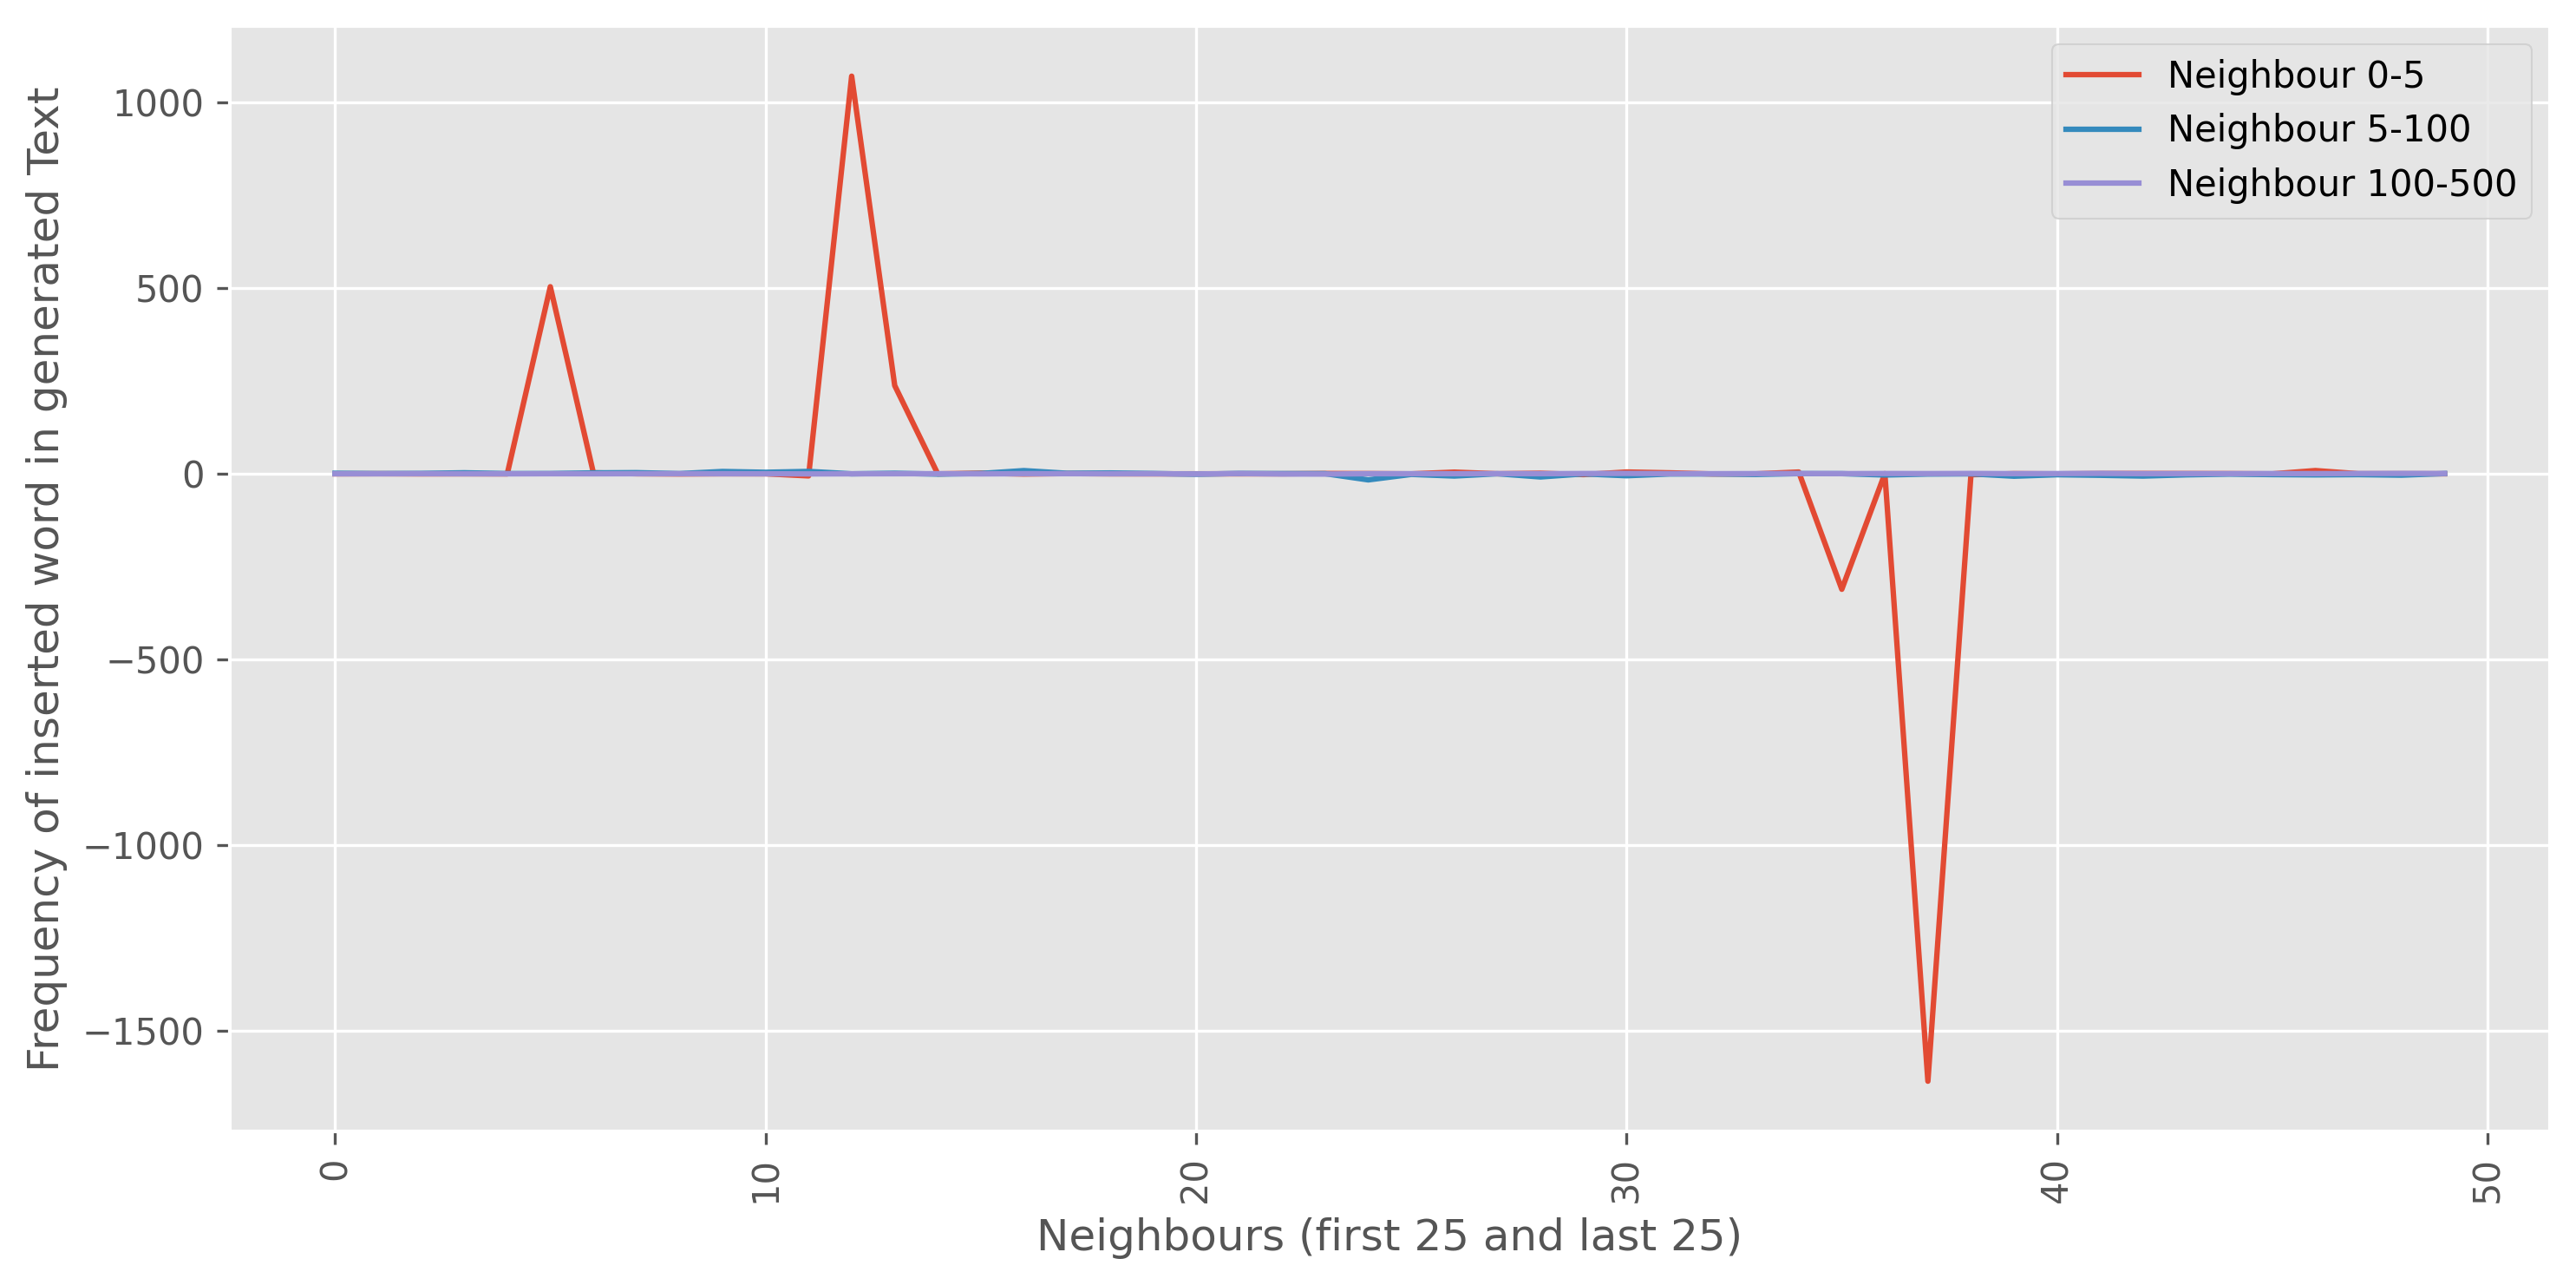

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


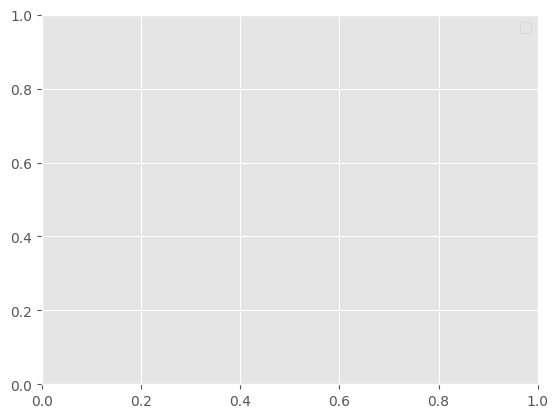

In [380]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10,5), dpi=300)

for i in [(0,10), (10, 20),(100, 500)]:
    
    KS = np.array(top_k(relative_semantic_drift, [i[0], i[1]]))
    mean_values = np.nanmean(KS, axis=0)
    xaxis = list(range(50))
    
    plt.plot(xaxis, mean_values, label=f'Neighbour {i[0]}-{i[1]}')

plt.ylabel('Frequency of inserted word in generated Text')  # Set y label
plt.xlabel('Neighbours (first 25 and last 25)')  # Set x label
plt.legend()
plt.tight_layout()
plt.xticks(rotation=90)
plt.savefig("final_plots/kneighbours_semantic_drift_comp.png")
plt.show()
plt.legend()
plt.show()

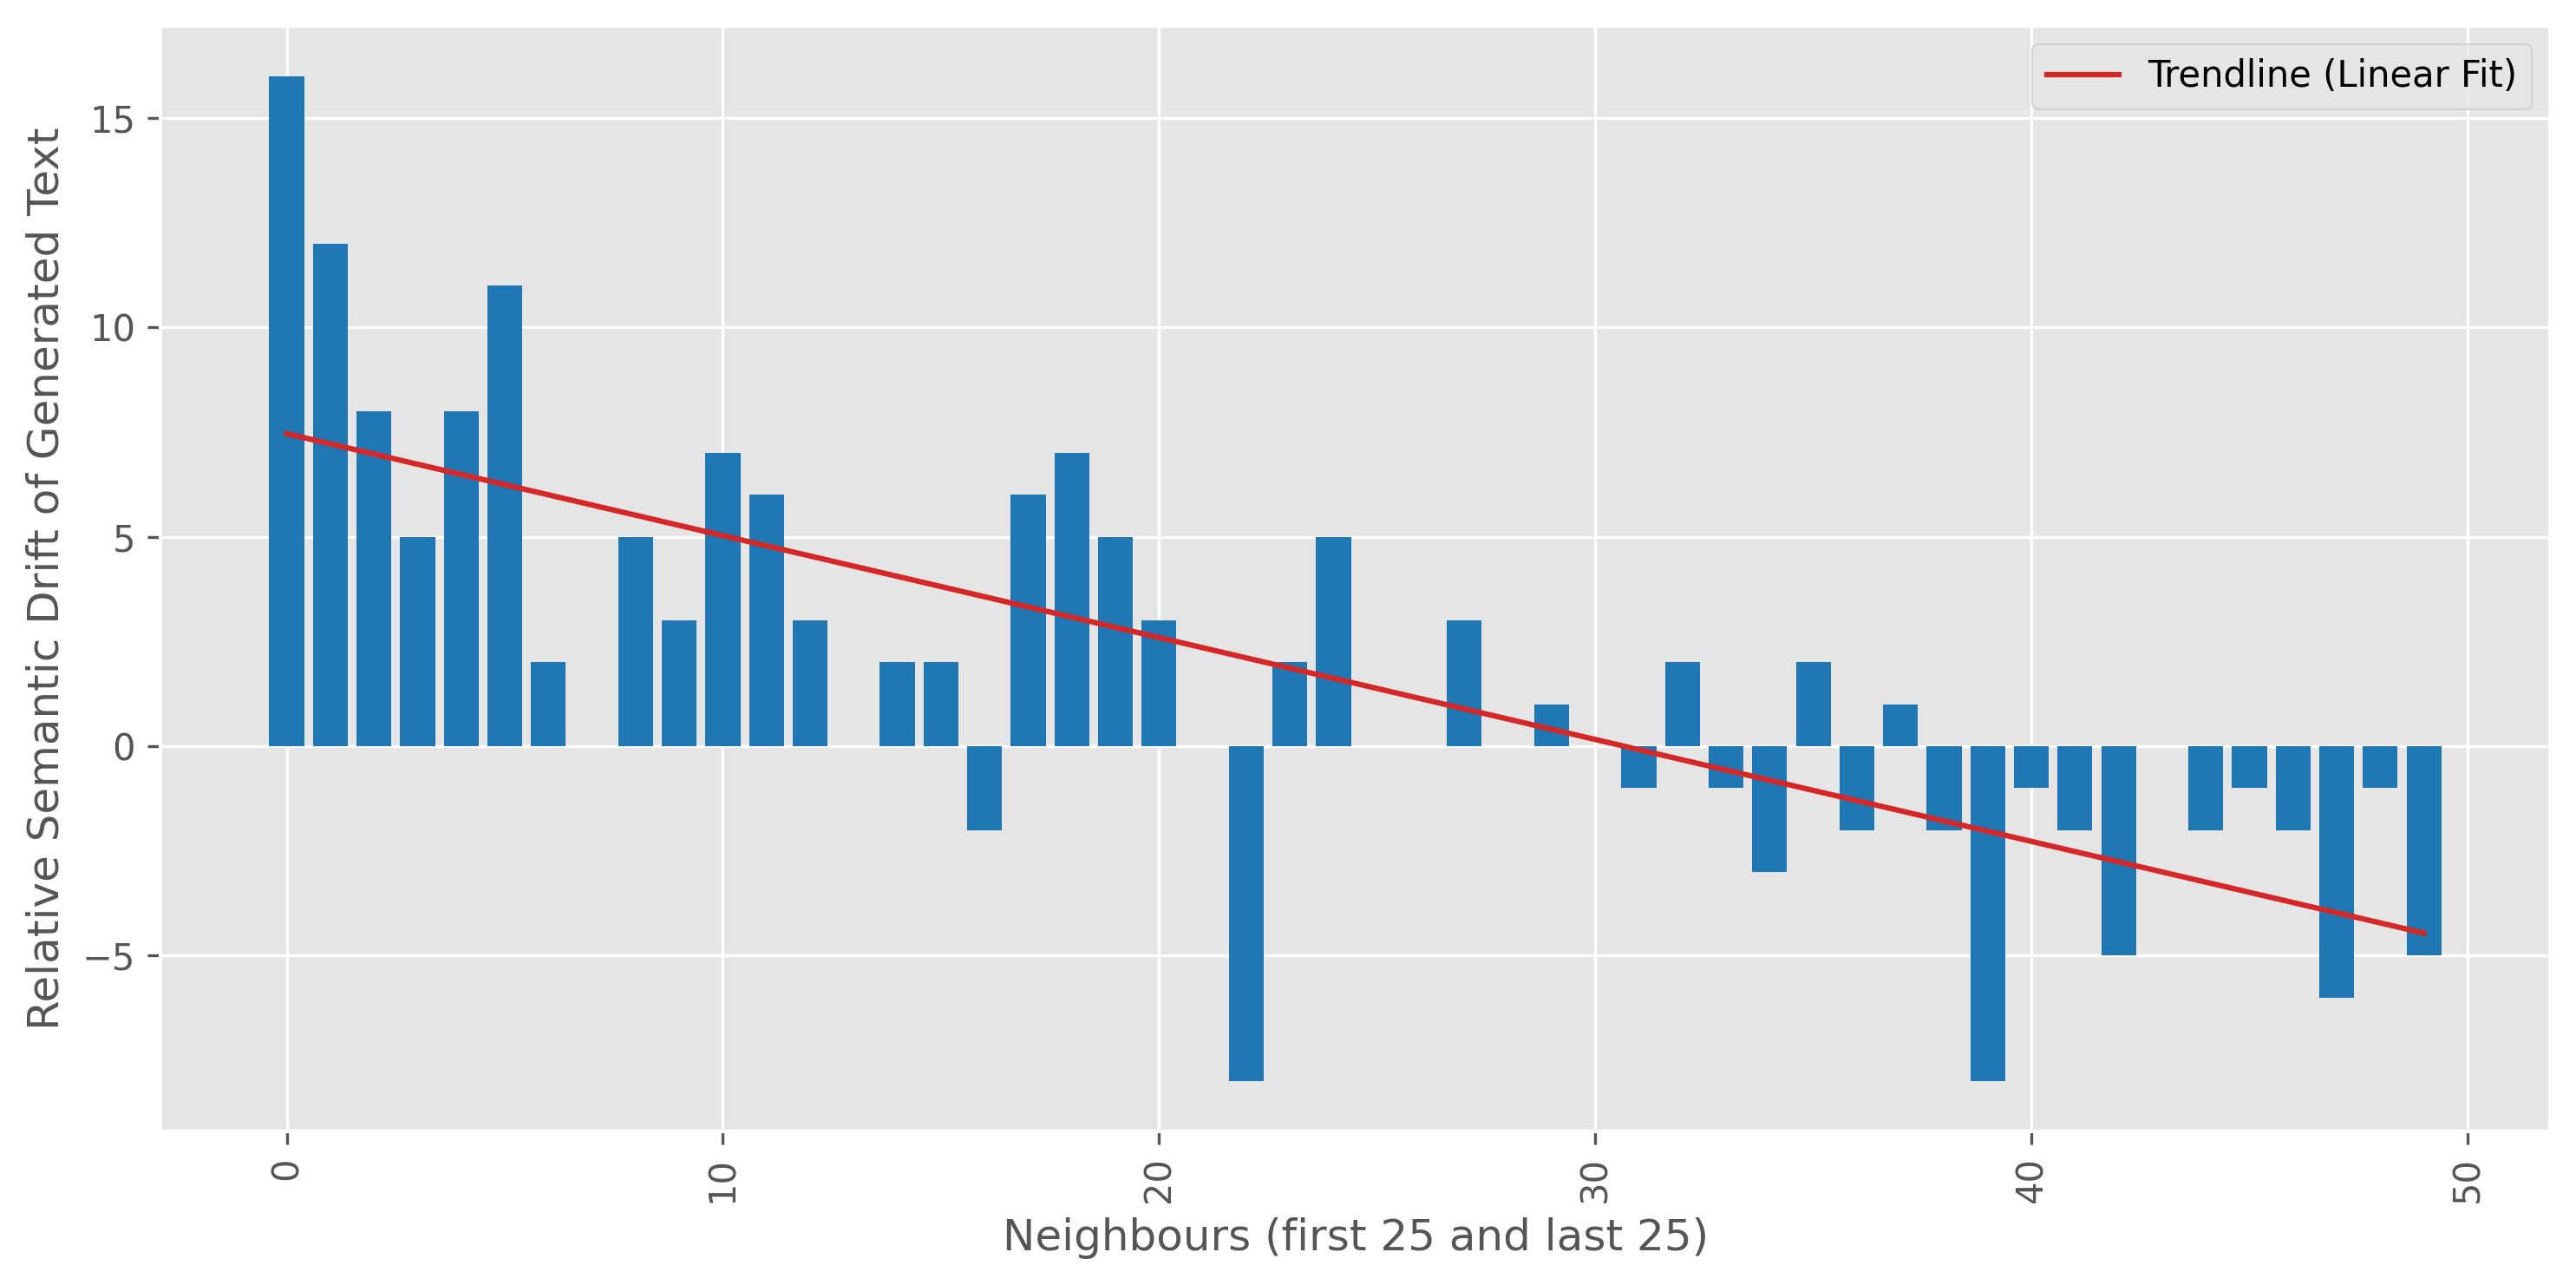

In [360]:
# mean_valuesimport matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10,5), dpi=300)

KS = np.array(top_k(relative_em_drift, [0, 50]))
mean_values = np.sum(KS, axis=0)
xaxis = list(range(50))

coefficients = np.polyfit(xaxis, mean_values, 1)
trendline = np.poly1d(coefficients)

ax.bar(xaxis, mean_values, color='tab:blue')
ax.set_ylabel('Relative Semantic Drift of Generated Text') 
ax.set_xlabel('Neighbours (first 25 and last 25)')
ax.plot(xaxis, trendline(xaxis), color='tab:red', label='Trendline (Linear Fit)')

# Show the plot
# plt.axvline(x=25, color='r', linestyle='--')

plt.legend()
plt.tight_layout()
plt.xticks(rotation=90)
plt.savefig("final_plots/kneighbours_em_drift_first.png")
plt.show()

In [ ]:
# mean_valuesimport matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10,4), dpi=300)


distances = np.array(drift)
coefficients = np.polyfit(distances[notnan], similarity_to_current[notnan], 1)
trendline = np.polyval(coefficients, distances[notnan])
ax.scatter(distances, similarity_to_current, marker='o', color="tab:blue", label="Neighbour", s=1)
ax.plot(distances[notnan], trendline, color='tab:red', label='Trendline (Linear Fit)')

# # Calculate the mean and standard deviation
mean_values = np.nanmean(similarity_to_current, axis=0)
std_values = np.nanstd(similarity_to_current, axis=0)

ax.plot(list(range(50)), mean_values, color='tab:blue', label='Trendline (Linear Fit)')
plt.fill_between(list(range(50)), mean_values - std_values, mean_values + std_values, alpha=0.2, label='Standard Deviation', color="tab:blue")

# Set the title and labels
ax.set_ylabel('Semantic Drift of Generated Text') 
ax.set_xlabel('Neighbours (first 25 and last 25)')

# Show the plot
plt.legend()
plt.tight_layout()
plt.savefig("final_plots/kneighbours.png")
plt.show()

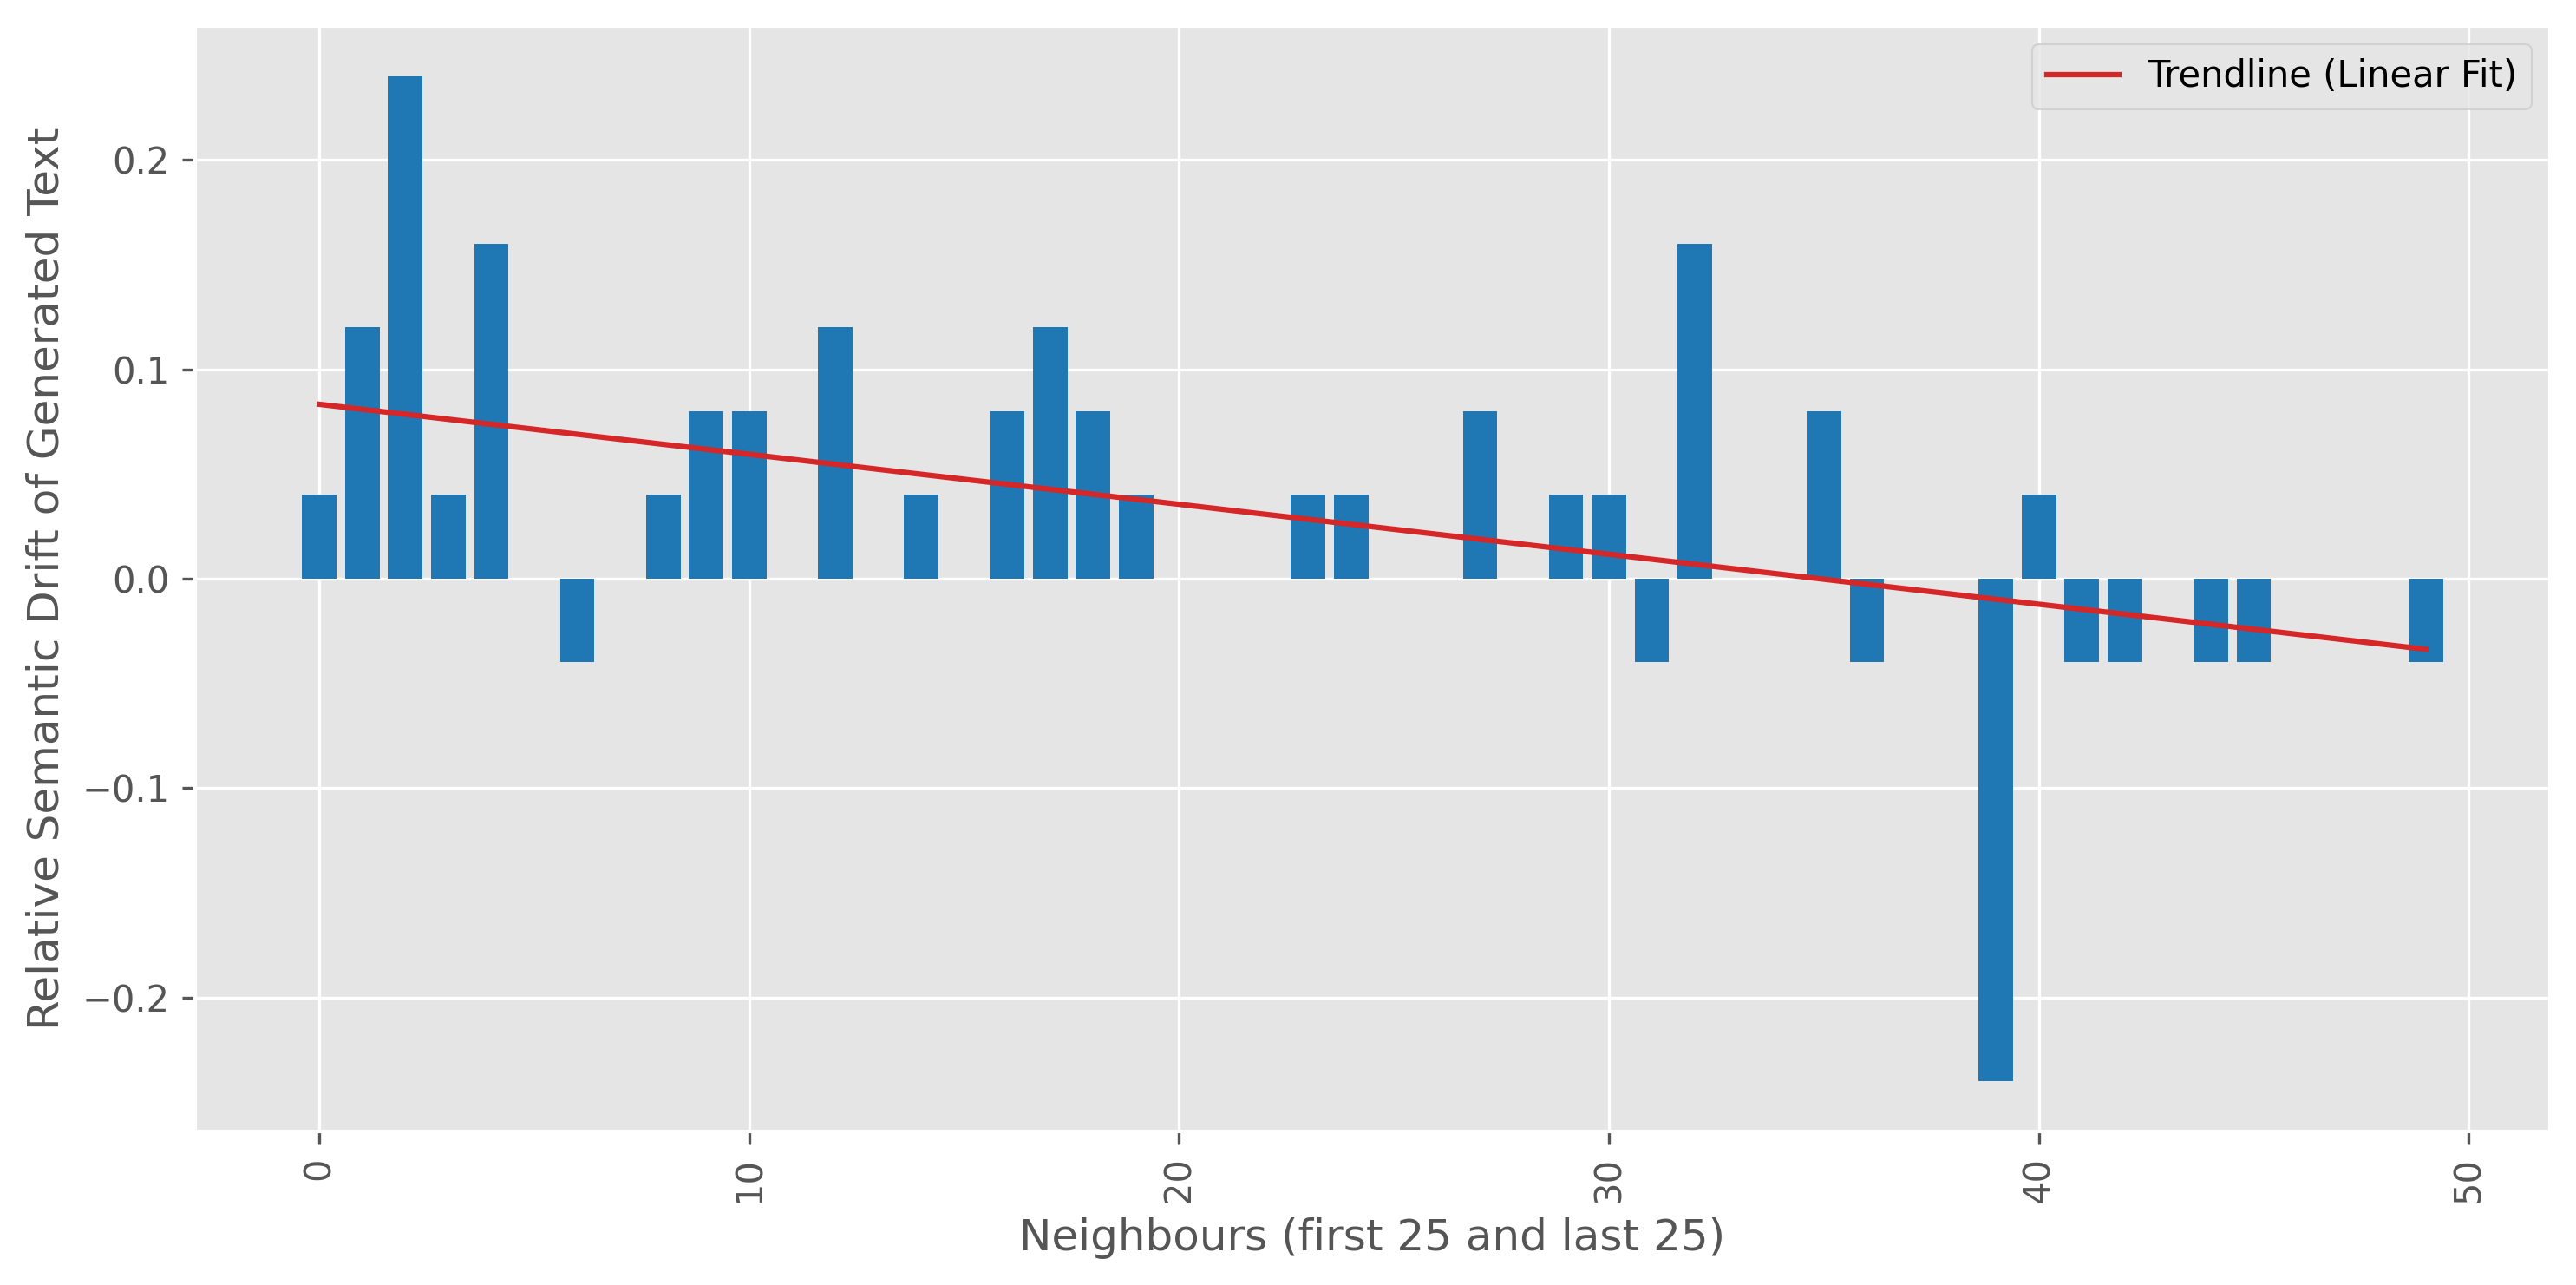

In [311]:
# mean_valuesimport matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10,5), dpi=300)

KS = np.array(top_k(relative_em_drift, [25, 50]))
mean_values = np.nanmean(KS, axis=0)
xaxis = list(range(50))

coefficients = np.polyfit(xaxis, mean_values, 1)
trendline = np.poly1d(coefficients)

ax.bar(xaxis, mean_values, color='tab:blue')
ax.set_ylabel('Relative Semantic Drift of Generated Text') 
ax.set_xlabel('Neighbours (first 25 and last 25)')
ax.plot(xaxis, trendline(xaxis), color='tab:red', label='Trendline (Linear Fit)')

# Show the plot
# plt.axvline(x=25, color='r', linestyle='--')

plt.legend()
plt.tight_layout()
plt.xticks(rotation=90)
plt.savefig("final_plots/kneighbours_em_drift_rest.png")
plt.show()

In [109]:
similarity_to_current.shape

(0,)

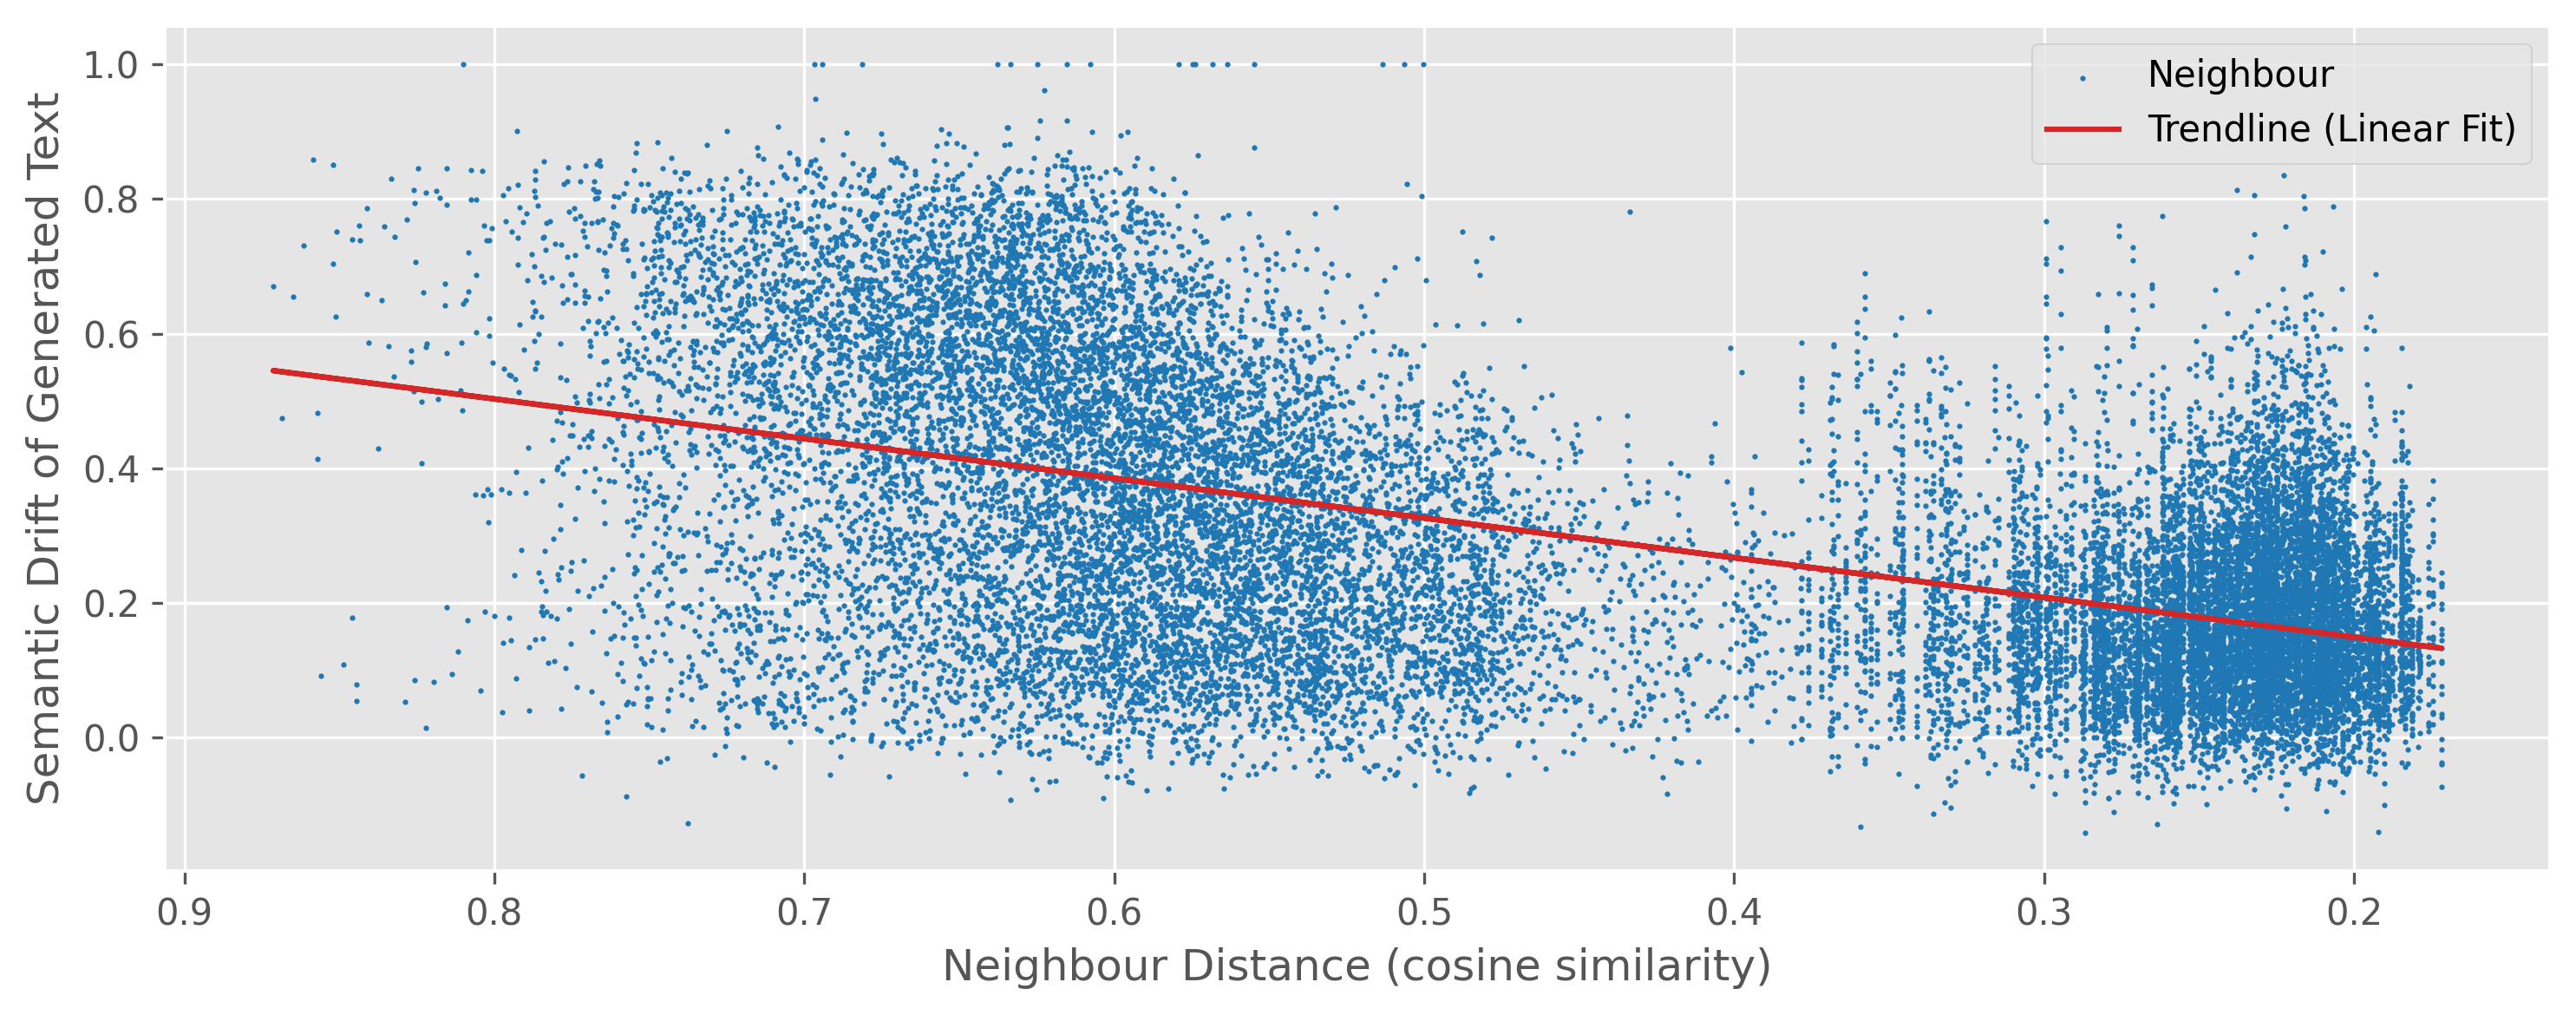

In [113]:
# mean_valuesimport matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10,4), dpi=300)

# # Calculate the mean and standard deviation
# mean_values = np.nanmean(base_model_similarity_to_target_new, axis=0)
# std_values = np.nanstd(base_model_similarity_to_target_new, axis=0)

# Create a bar chart with error bars and markers
notnan = ~np.isnan(similarity_to_current)

distances = np.array(distances)
coefficients = np.polyfit(distances[notnan], similarity_to_current[notnan], 1)
trendline = np.polyval(coefficients, distances[notnan])
ax.scatter(distances, similarity_to_current, marker='o', color="tab:blue", label="Neighbour", s=1)
ax.plot(distances[notnan], trendline, color='tab:red', label='Trendline (Linear Fit)')

# plt.fill_between(distances, mean_values - std_values, mean_values + std_values, alpha=0.2, label='Standard Deviation')

# Set the title and labels
ax.set_ylabel('Semantic Drift of Generated Text') 
ax.set_xlabel('Neighbour Distance (cosine similarity)')
plt.gca().invert_xaxis()

# Show the plot
plt.legend()
plt.tight_layout()
plt.savefig("final_plots/neighbour_distance.png")
plt.show()